In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale, MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 128
use_gpu = True
y_scale = True
lr = 0.0005
weight_decay = 0.0001

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')


columns = X.columns


In [6]:
columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

## Imputer, Scaler, Feature selection

In [7]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2, step3])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)
X_test = X_test.drop(columns=['building_id'], axis=1)


### X sacle

In [9]:
X = pipeline.fit_transform(X)
print(X.shape)

X_test = pipeline.transform(X_test)
print(X_test.shape)

(60000, 211)
(10000, 211)


In [10]:
ran = y.max() - y.min()
print(ran)
y.describe()

5088052947.245064


count    6.000000e+04
mean     1.293727e+07
std      5.522463e+07
min      2.261495e+05
25%      2.433114e+06
50%      5.240482e+06
75%      1.123932e+07
max      5.088279e+09
Name: total_price, dtype: float64

### y scale 

In [11]:
#y_scaler = StandardScaler()
#y_scaler = MaxAbsScaler() # sparse
y_scaler = MinMaxScaler(feature_range=[0, 1])
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [12]:
y

array([[8.28321267e-05],
       [6.08347143e-04],
       [1.83660349e-03],
       ...,
       [2.27773819e-03],
       [3.50995685e-03],
       [1.62815648e-03]])

In [13]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [14]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 211])
torch.Size([10000, 211])
torch.Size([42000, 1])


In [16]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [17]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(211, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(num_features=512)
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(num_features=512)
        
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(num_features=256)
        
        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(num_features=128)
        
        self.fc6 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(num_features=64)
        
        self.fc7 = nn.Linear(64, 32)
        self.bn7 = nn.BatchNorm1d(num_features=32)
        
        self.fc8 = nn.Linear(32, 1)
        
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = self.fc8(x)

        return x

In [18]:
model = DNN().to(device)
model.apply(weights_init_uniform)
criterion = nn.MSELoss()
#optim = optim.Adam(model.parameters(), lr= lr)
optim = optim.SGD(model.parameters(), lr= lr)

In [21]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = torch.sqrt(criterion(pred, batch_y))
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = torch.sqrt(criterion(pred, batch_y))
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return np.array(eval_loss).mean()

def test_func(model, X):
    model.eval()
    with torch.no_grad():
        pred = model(X)
        
        pred = pred.cpu().numpy()
        if y_scale:
            pred = y_scaler.inverse_transform(pred)            
    return pred


def accuracy(model, pct_close=0.5):
    #pred, y_eval
    model.eval()
    with torch.no_grad():
        pred = model(X_eval)
        
    n_correct = torch.sum((torch.abs(pred - y_eval) < torch.abs(pct_close * y_eval)))
    result = (n_correct.item()/len(y_eval))  # scalar
    return result 

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [ ]:
train_losses = []
eval_losses = []
#accs = []
for t in range(5000):
    print('epochs', t)
    train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        #acc = accuracy(model)
        
        eval_losses.append(eval_loss)
        train_losses.append(train_loss)
        
        #accs.append(acc)
        #print('accuracy: ',acc)

epochs 0
training loss 7.757733353727857
epochs 1
training loss 4.869616896910508
epochs 2
training loss 2.656036224771053
epochs 3
training loss 0.987369618154949
epochs 4
training loss 0.1594524697420445
epochs 5
training loss 0.08364216624376984
epochs 6
training loss 0.06658315844267697
epochs 7
training loss 0.05595757138538868
epochs 8
training loss 0.0434831399357337
epochs 9
training loss 0.03101975721587345
testing loss 0.027255225761509533
epochs 10
training loss 0.021338753427710033
epochs 11
training loss 0.013311693132755922
epochs 12
training loss 0.009517531914177908
epochs 13
training loss 0.008789948289676096
epochs 14
training loss 0.008574305208029062
epochs 15
training loss 0.008201966389141817
epochs 16
training loss 0.007970483688422476
epochs 17
training loss 0.0078529944122517
epochs 18
training loss 0.007594428021647602
epochs 19
training loss 0.007398072979766819
testing loss 0.008392489594506456
epochs 20
training loss 0.0072353095390146034
epochs 21
training

training loss 0.0065788087020359235
epochs 171
training loss 0.006599082731454998
epochs 172
training loss 0.006449920552751576
epochs 173
training loss 0.006638270587303695
epochs 174
training loss 0.006560761761061825
epochs 175
training loss 0.006590016605190955
epochs 176
training loss 0.006614301734785111
epochs 177
training loss 0.006587463702814014
epochs 178
training loss 0.0065802633748205785
epochs 179
training loss 0.0064861448092448405
testing loss 0.007192077915223831
epochs 180
training loss 0.006646287191933797
epochs 181
training loss 0.006489354950421147
epochs 182
training loss 0.006588032854491658
epochs 183
training loss 0.006575350394531926
epochs 184
training loss 0.006641523599395341
epochs 185
training loss 0.006570450745743776
epochs 186
training loss 0.006598848884211893
epochs 187
training loss 0.006617256917206622
epochs 188
training loss 0.006548602416358413
epochs 189
training loss 0.00658730280976233
testing loss 0.00801090740744051
epochs 190
training lo

training loss 0.006573342899706973
epochs 337
training loss 0.006476160321076114
epochs 338
training loss 0.006644068989976335
epochs 339
training loss 0.0066472104284204655
testing loss 0.007452625276005649
epochs 340
training loss 0.006643609057455168
epochs 341
training loss 0.006431681619204105
epochs 342
training loss 0.006625445785020736
epochs 343
training loss 0.006610166868492169
epochs 344
training loss 0.006597515072469744
epochs 345
training loss 0.0066628186545252665
epochs 346
training loss 0.00661892944551993
epochs 347
training loss 0.006477860277405399
epochs 348
training loss 0.0065154865462655675
epochs 349
training loss 0.006516161088132523
testing loss 0.007526349471155422
epochs 350
training loss 0.006484328083040074
epochs 351
training loss 0.006532548982324503
epochs 352
training loss 0.006505370165906439
epochs 353
training loss 0.006461290829095956
epochs 354
training loss 0.006541187178603965
epochs 355
training loss 0.006519784313332187
epochs 356
training l

training loss 0.006554855537631954
epochs 503
training loss 0.006510293226912731
epochs 504
training loss 0.007146237280055609
epochs 505
training loss 0.006518146347631007
epochs 506
training loss 0.006558205031840793
epochs 507
training loss 0.0065793750728381445
epochs 508
training loss 0.00665103023663718
epochs 509
training loss 0.006570431062000546
testing loss 0.00728666788901711
epochs 510
training loss 0.006588077022606297
epochs 511
training loss 0.006523149781917027
epochs 512
training loss 0.006550826336466637
epochs 513
training loss 0.006595251206690757
epochs 514
training loss 0.006534411213827803
epochs 515
training loss 0.006507090323655597
epochs 516
training loss 0.006617390828442089
epochs 517
training loss 0.006596533445737645
epochs 518
training loss 0.006595994977458836
epochs 519
training loss 0.006605922981550334
testing loss 0.007095547452410485
epochs 520
training loss 0.006624949820365157
epochs 521
training loss 0.0065947593374483535
epochs 522
training los

training loss 0.006609882565645507
testing loss 0.007345991361892868
epochs 670
training loss 0.006598087347191858
epochs 671
training loss 0.006562367818349446
epochs 672
training loss 0.006546816706167687
epochs 673
training loss 0.006597120375698008
epochs 674
training loss 0.0065391126338613294
epochs 675
training loss 0.006566629828573813
epochs 676
training loss 0.00658190844185639
epochs 677
training loss 0.00659012279188753
epochs 678
training loss 0.006597082065857132
epochs 679
training loss 0.006641759377929713
testing loss 0.00850573293072112
epochs 680
training loss 0.006569565101144524
epochs 681
training loss 0.006543656774318146
epochs 682
training loss 0.0064993786677225605
epochs 683
training loss 0.00657626271982448
epochs 684
training loss 0.006570228683694314
epochs 685


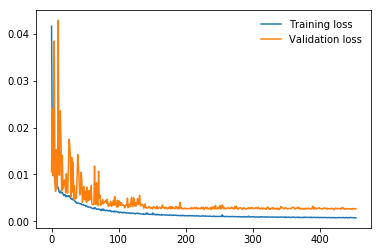

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)

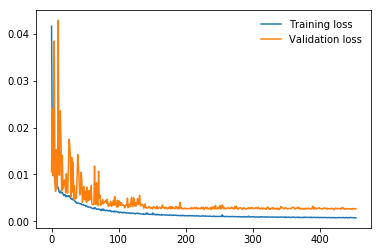

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)


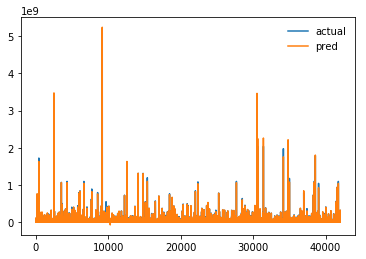

In [23]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [24]:
pred = test_func(model, X_test)


In [25]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.787341e+07
1,BTshNOJyKHnT2YIT,4.164898e+06
2,dhdymr0lV8N5kZOT,1.366612e+07
3,VEwyGGMcD56w5BOc,1.343023e+07
4,wmUeMoJZfsqaSX9b,1.932745e+06
5,EtBjGAHmHCe9t7TZ,5.281519e+06
6,hPNH34vmaZtvBtqc,1.480271e+07
7,wXjeI38bYDMJJwZC,1.103791e+07
8,fxZSGX6aPAFKU8W4,2.926602e+06
9,ewr0Fx6ign87OwaV,6.620901e+06


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512

Result 2 lr=0.001, batch_size=64, DNN 233->256->128->64->1
after 1k loss : 0.00011785521522113447, can't decrease...
- x_scale false
- y_scale true

Result 3 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->1
after 1w loss : 0.0003, test loss : 0.0007 score: 1670

Result 4 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1
train_loss: 0.0004, test loss: 0.0002 score: 1600

Result 5 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram
train_loss: 0.0005, test loss: 0.003 score: 1000

Result 6 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->1 + batch_noram + weight_decay
after 2k
train_loss: 0.004, test loss 0.006 ,look like L2 regular not work which will increase loss

Result 6 lr=0.0015 batch_size=128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram
after 3k
train_loss 0.0004 test loss 0.002 score : 1400
I think we should reduce lr or add L2 regularzation

Result 7 lr=0.0015 batch_size= 128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram + weight_decay(0.0005)
after 3.5k 
train loss 0.0007, test loss 0.002, score: 2217
regularzation is work, but test loss is not reduce, next tuning lr



### question

why output is negative?